In [1]:
import pyart
#imports
import os # Code for dealing with the file system
import numpy as np
from matplotlib import pyplot as plt
from dask.distributed import Client, progress, metrics, LocalCluster
from netCDF4 import num2date

%matplotlib inline



## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/home/scollis/anaconda3/envs/daskenv/lib/python3.6/site-packages/pyart/graph/cm.py:104: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:
/home/scollis/anaconda3/envs/daskenv/lib/python3.6/site-packages/pyart/graph/cm_colorblind.py:32: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'red' in spec:


In [2]:
in_directory = '/lustre/or-hydra/cades-arm/proj-shared/xsapr_tute/'

Create and sort a list of files.


In [3]:
all_files = os.listdir(in_directory)
all_files.sort()

In [4]:
test_file_name = os.path.join(in_directory, all_files[23])
print(test_file_name)

test_dataset = pyart.io.read(test_file_name)

/lustre/or-hydra/cades-arm/proj-shared/xsapr_tute/sgpxsaprI5.00.20170801.031101.mnt.XSW170801025004.RAWG2UE.maint


In [5]:
test_dataset.time

{'units': 'seconds since 2017-08-01T02:50:04Z',
 'standard_name': 'time',
 'long_name': 'time_in_seconds_since_volume_start',
 'calendar': 'gregorian',
 'comment': 'Coordinate variable for time. Time at the center of each ray, in fractional seconds since the global variable time_coverage_start',
 'data': array([  7.694,   7.751,   7.809, ..., 526.092, 526.151, 526.197])}

Lets plot one day's worth of data


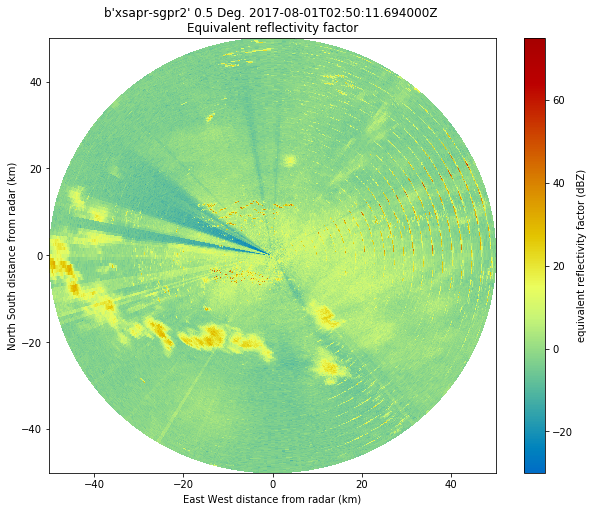

In [6]:
my_figure = plt.figure(figsize=[10,8])
myd = pyart.graph.RadarDisplay(test_dataset)
myd.plot_ppi('reflectivity', 0)

In [7]:
tgates = float(test_dataset.ngates*test_dataset.nrays)
zdat = test_dataset.fields['reflectivity']['data']
z0 = float(len(np.where(zdat > 0.)[0]))/tgates
z10 = float(len(np.where(zdat > 10.)[0]))/tgates
z40 = float(len(np.where(zdat > 40.)[0]))/tgates

In [8]:
print("Fraction of: Gates over 0 dBz: {}, Gates over 10 dBz: {}, Gates over 40 dBz: {}".format(z0, z10, z40 ))

Fraction of: Gates over 0 dBz: 0.10935305315295335, Gates over 10 dBz: 0.01767806978635322, Gates over 40 dBz: 5.428956901012789e-05


In [9]:
del test_dataset

In [10]:
fqn_files = [os.path.join(in_directory,thisfile) for thisfile in all_files]

In [13]:
def load_mods():
    import os
    import pyart

In [14]:
def analyze_radar(filename):
    try:
        os.environ['PROJ_LIB'] = '/nfs/data/arm/jupyter/daskenv/share/proj/'
        this_dataset = pyart.io.read(filename)
        fp = 1
        time_start = num2date(this_dataset.time['data'][0], this_dataset.time['units'])
        tgates = float(this_dataset.ngates*this_dataset.nrays)
        zdat = this_dataset.fields['reflectivity']['data']
        fp = 2
        z0 = float(len(np.where(zdat > 0.)[0]))/tgates
        z10 = float(len(np.where(zdat > 10.)[0]))/tgates
        z40 = float(len(np.where(zdat > 40.)[0]))/tgates
        del this_dataset
        rv = (time_start, z0, z10, z40)
    except:
        rv = 'NotOK'
        
    return rv

In [15]:
analyze_radar(fqn_files[10])

(datetime.datetime(2017, 8, 1, 0, 40, 13, 126000),
 0.07848977969985954,
 0.02914333370296444,
 7.161602720484957e-05)

In [16]:
client = Client('arm-jupyter.ornl.gov:5555')

In [17]:
client

Client Scheduler: tcp://arm-jupyter.ornl.gov:5555 Dashboard: http://arm-jupyter.ornl.gov:8787/status,Cluster Workers: 6 Cores: 36 Memory: 256.02 GB


In [18]:
client.run(load_mods)

{'tcp://172.23.217.96:34551': None,
 'tcp://172.23.217.96:34618': None,
 'tcp://172.23.217.96:36569': None,
 'tcp://172.23.217.96:38223': None,
 'tcp://172.23.217.96:44991': None,
 'tcp://172.23.217.96:46058': None}

In [19]:
future = client.map(analyze_radar, fqn_files)

In [20]:
progress(future)


VBox()

In [21]:
my_data = client.gather(future)

In [25]:
times = np.array([tpl[0] for tpl in my_data])
z0 = np.array([tpl[1] for tpl in my_data])
z10 = np.array([tpl[2] for tpl in my_data])
z40 = np.array([tpl[3] for tpl in my_data])

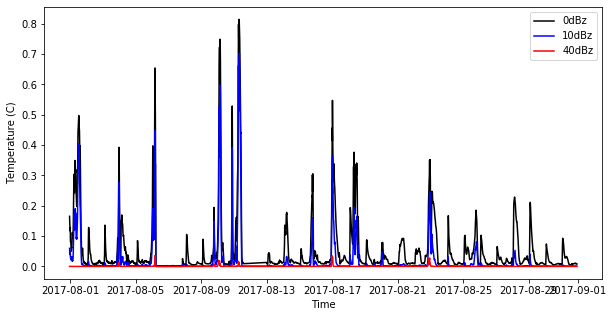

In [27]:
my_fig = plt.figure(figsize=[10,5])
plt.plot(times, z0, '-k', label='0dBz')
plt.plot(times, z10, '-b', label='10dBz')
plt.plot(times, z40, '-r', label='40dBz')
plt.ylabel('Temperature (C)')
plt.xlabel('Time')
plt.legend()
